<a href="https://colab.research.google.com/github/bilzkaist/ActivityTransformer/blob/main/ActivityTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mouting Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Dataset Path

In [2]:
dataset_Path = '/content/gdrive/MyDrive/Datasets/'

## Model Path

In [3]:
model_Path = '/content/gdrive/MyDrive/models/'

## Load Dataset

In [4]:
DATA_PATH = dataset_Path + 'WAR_Dataset.csv'
print(DATA_PATH)

/content/gdrive/MyDrive/Datasets/WAR_Dataset.csv


## Import Libraries

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from scipy import stats
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pickle
import matplotlib
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()


## Labels

In [6]:
##################################################
### GLOBAL VARIABLES
##################################################
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]


LABELS = [
    'Static',
    'Dynamic',
    'Upper Floor',
    'Lower Floor'
] 



RANDOM_SEED = 13

# Data preprocessing
TIME_STEP = 100

# Model
N_CLASSES_HAR = 6
N_CLASSES = 4
N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration

# Hyperparameters optimized
SEGMENT_TIME_SIZE = 180
N_HIDDEN_NEURONS = 30
BATCH_SIZE = 32

## Load Data




In [8]:
# LOAD DATA
try:
  data = pd.read_csv(DATA_PATH, header=None, skiprows=1, names=COLUMN_NAMES)
  dataV = pd.read_csv(DATA_PATH, header=None, skiprows=1, names=COLUMN_NAMES)
except:
  print("Exception : ")
  data = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES, error_bad_lines=False)
  dataV = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES, error_bad_lines=False)




In [9]:

dataV['z-axis'] = dataV['z-axis'].replace({';': ''}, regex=True).astype(float)

In [10]:
data['z-axis'].replace({';': ''}, regex=True, inplace=True)
data = data.dropna()

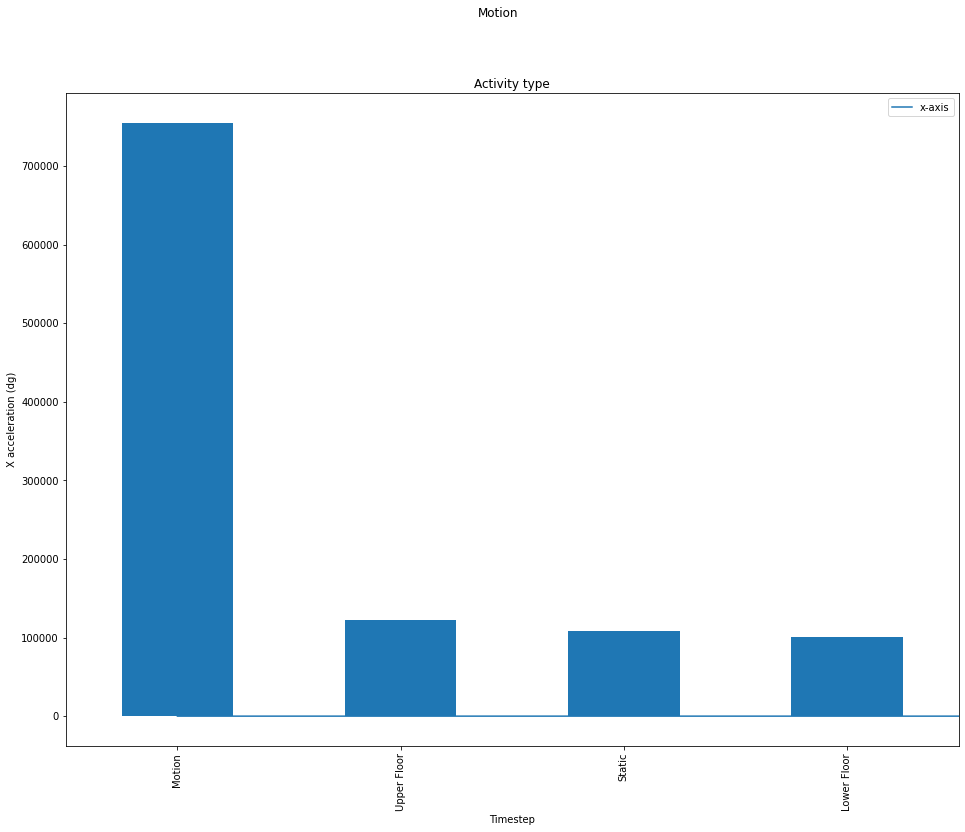

In [11]:

# SHOW GRAPH FOR JOGGING
data[data['activity'] == 'Motion'][['x-axis']][:50].plot(subplots=True, figsize=(16, 12), title='Motion')
plt.xlabel('Timestep')
plt.ylabel('X acceleration (dg)')

# SHOW ACTIVITY GRAPH
activity_type = data['activity'].value_counts().plot(kind='bar', title='Activity type')
#plt.show()

# DATA PREPROCESSING
data_convoluted = []
labels = []

In [12]:
df = dataV

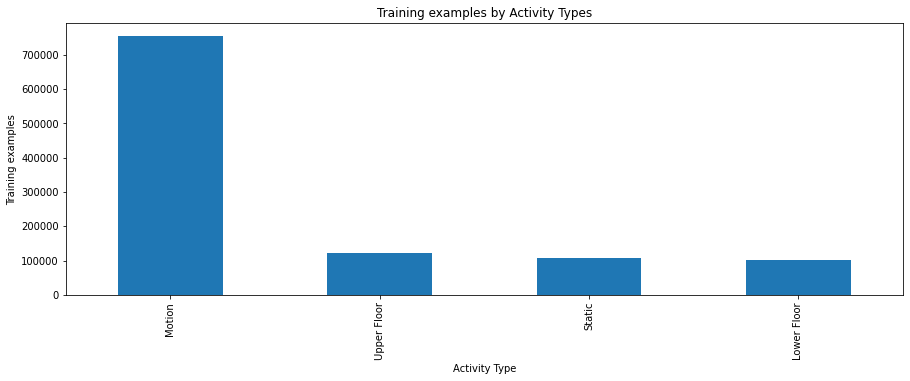

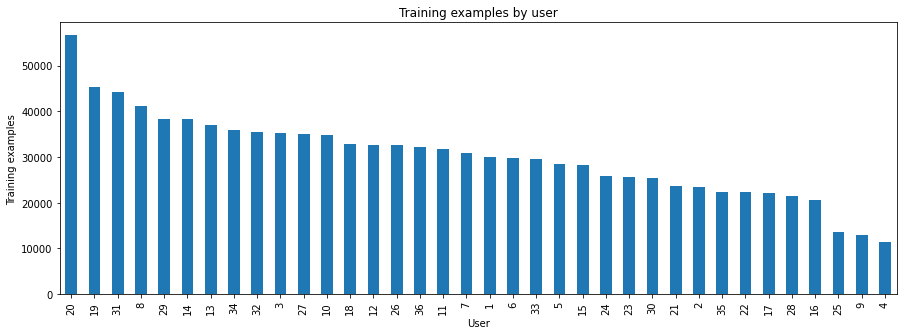

In [13]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Training examples')
df['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Training examples')
df['user'].value_counts().plot(kind='bar', 
                                 title='Training examples by user')
plt.show()

## Visualization of the Accelerometer Data

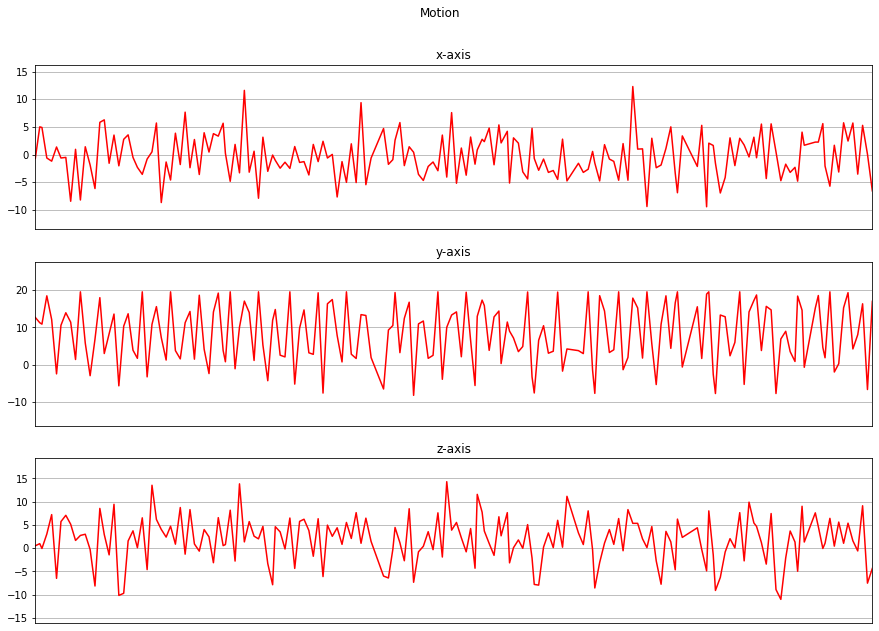

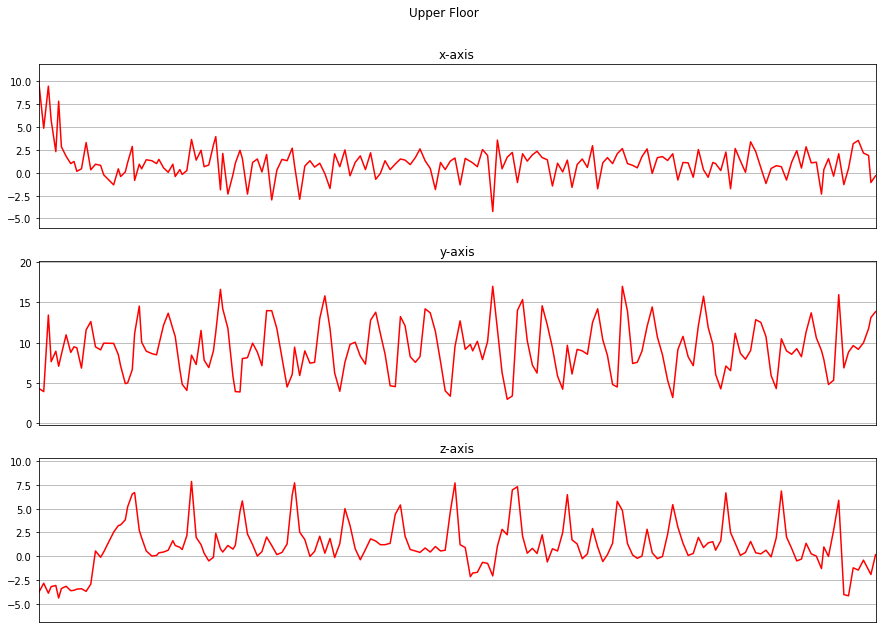

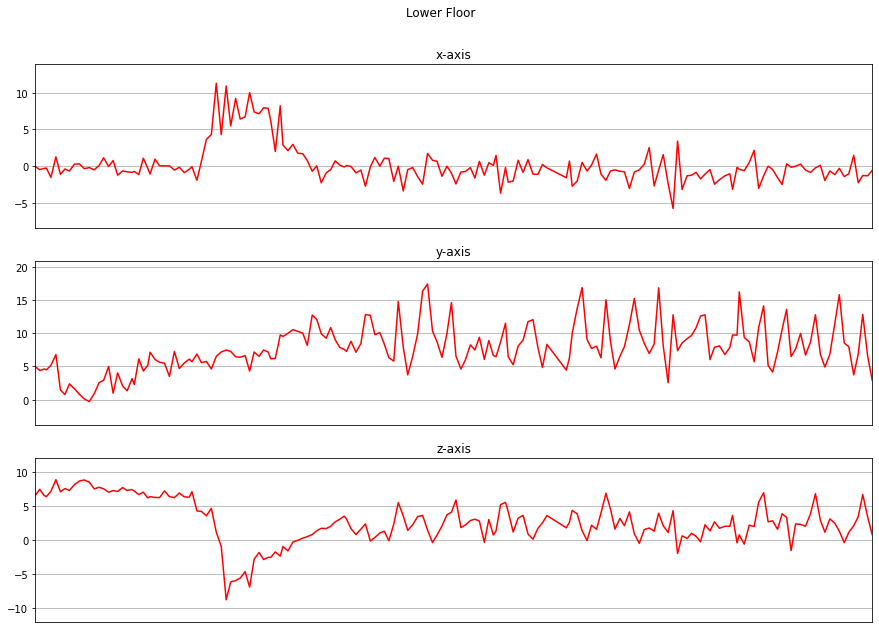

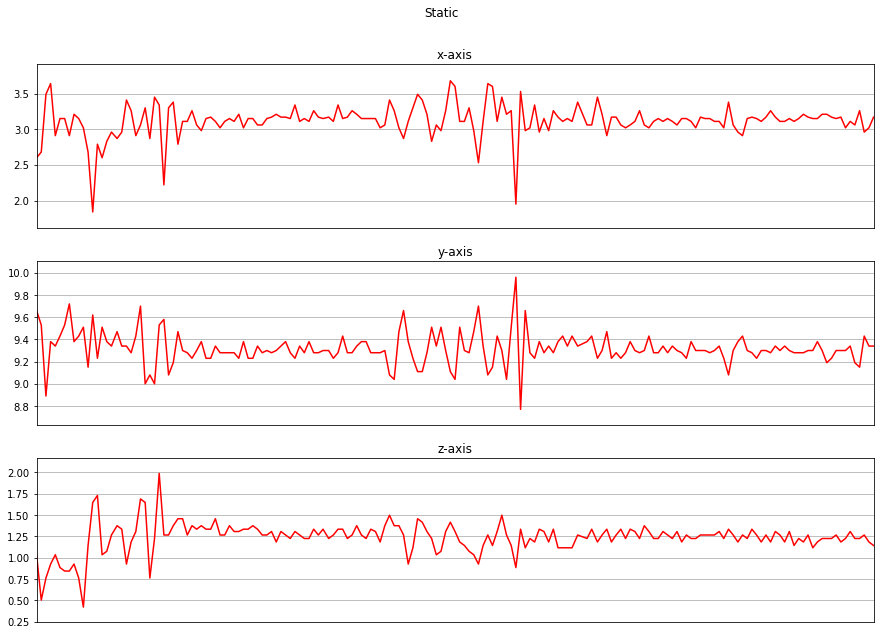

In [14]:
def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
for activity in df['activity'].unique():
    limit = df[df['activity'] == activity][:180]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))
    axis_plot(ax0, limit['timestamp'], limit['x-axis'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['y-axis'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

## Data preprocessing
#### Data preprocessing is a very important task in preparing our raw data to easily parse through our model. The data preprocessing methods that we will be using are:

### Label Encoding
### Linear Interpolation
### Data Split
### Normalization
### Segmentation
### One-Hot Encoding

## AcT: Activity Transformer Model

In [15]:
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, LayerNormalization
from keras.layers import MultiHeadAttention, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.models import Model

# Define the Activity Transformer model
def AcT(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = LayerNormalization()(x)
    x = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
    x = Dropout(0.2)(x)
    x = LayerNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(64, kernel_size=3, activation='relu')(x)
    x = LayerNormalization()(x)
    x = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
    x = Dropout(0.2)(x)
    x = LayerNormalization()(x)
    x = MaxPooling1D(2)(x)

    # Decoder
    x = Conv1D(32, kernel_size=3, activation='relu')(x)
    x = LayerNormalization()(x)
    x = MultiHeadAttention(num_heads=8, key_dim=32)(x, x)
    x = Dropout(0.2)(x)
    x = LayerNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(32, kernel_size=3, activation='relu')(x)
    x = LayerNormalization()(x)
    x = MultiHeadAttention(num_heads=8, key_dim=32)(x, x)
    x = Dropout(0.2)(x)
    x = LayerNormalization()(x)
    x = MaxPooling1D(2)(x)

    # Output
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

## Load Data

## Segmentation

In [16]:
# Slide a "SEGMENT_TIME_SIZE" wide window with a step size of "TIME_STEP"
for i in range(0, len(data) - SEGMENT_TIME_SIZE, TIME_STEP):
    x = data['x-axis'].values[i: i + SEGMENT_TIME_SIZE]
    y = data['y-axis'].values[i: i + SEGMENT_TIME_SIZE]
    z = data['z-axis'].values[i: i + SEGMENT_TIME_SIZE]
    data_convoluted.append([x, y, z])

    # Label for a data window is the label that appears most commonly
    label = stats.mode(data['activity'][i: i + SEGMENT_TIME_SIZE])[0][0]
    labels.append(label)

<ipython-input-16-a529c83ade2b>:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(data['activity'][i: i + SEGMENT_TIME_SIZE])[0][0]
<ipython-input-16-a529c83ade2b>:9: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  label = stats.mode(data['activity'][i: i + SEGMENT_TIME_SIZE])[0][0]


## One-Hot Encoding & Splitting of Datasets 

In [17]:
# Convert to numpy
data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)

# One-hot encoding
labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)
print("Convoluted data shape: ", data_convoluted.shape)
print("Labels shape:", labels.shape)


# SPLIT INTO TRAINING AND TEST SETS
X_train, X_test, Y_train, Y_test = train_test_split(data_convoluted, labels, test_size=0.3, random_state=RANDOM_SEED)
print("X train size: ", len(X_train))
print("X test size: ", len(X_test))
print("y train size: ", len(Y_train))
print("y test size: ", len(Y_test))

verbose = 1
epochs = 200
batch_size = 50

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = Y_train.shape[1]

Convoluted data shape:  (10863, 180, 3)
Labels shape: (10863, 4)
X train size:  7604
X test size:  3259
y train size:  7604
y test size:  3259


## Training of AcT Model

### Parameter Initialization

In [18]:
verbose = 1
epochs = 200
batch_size = 50

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = Y_train.shape[1]

input_shape=(n_timesteps,n_features)
inputs = Input(shape=input_shape)

print("input_shape = ",input_shape)
print("n_outputs = ",n_outputs)

input_shape =  (180, 3)
n_outputs =  4


### Initializing Model 

In [19]:
model = AcT(input_shape, n_outputs)

### Compiling of AcT Model

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Start Training of AcT Model

In [23]:
max_test_accuracy = 0
epochs = 0
val_acc = 0.0

while  epochs < 200:
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                        epochs=1, batch_size=batch_size,
                        verbose=verbose)
    
    # evaluate model
    (loss, accuracy) = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=verbose)
    print("[INFO] epoch: {}, loss={:.4f}, accuracy: {:.4f}%".format(epochs, loss, accuracy * 100))
    
    # check validation accuracy
    val_acc = history.history['val_accuracy'][-1]
    epochs += 1
    
    # check if current test accuracy is greater than previous max accuracy
    if accuracy > max_test_accuracy:
        # save the model to a file
        model.save(model_Path + '/Accuracy_Bilz_AcT_WAR_TrainedModelv4.h5')
        max_test_accuracy = accuracy
        print("Model saved with test accuracy {:.4f}%".format(max_test_accuracy * 100))
        print(model_Path + '/Accuracy_Bilz_AcT_WAR_TrainedModelv4.h5')
    print("..................................Max Test Accuracy achieved = {:.4f}%".format(max_test_accuracy * 100))
print("Training stopped at epoch {}, test accuracy reached ".format(epochs))





Train on 7604 samples, validate on 3259 samples
7604/7604 [==============================] - 7s 950us/sample - loss: 0.0081 - accuracy: 0.9970 - val_loss: 0.1297 - val_accuracy: 0.9736
[INFO] epoch: 0, loss=0.1297, accuracy: 97.3612%
Model saved with test accuracy 97.3612%
/content/gdrive/MyDrive/models//Accuracy_Bilz_AcT_WAR_TrainedModelv4.h5
..................................Max Test Accuracy achieved = 97.3612%
Train on 7604 samples, validate on 3259 samples
7604/7604 [==============================] - 6s 771us/sample - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.1348 - val_accuracy: 0.9773
[INFO] epoch: 1, loss=0.1348, accuracy: 97.7294%
Model saved with test accuracy 97.7294%
/content/gdrive/MyDrive/models//Accuracy_Bilz_AcT_WAR_TrainedModelv4.h5
..................................Max Test Accuracy achieved = 97.7294%
Train on 7604 samples, validate on 3259 samples
7604/7604 [==============================] - 6s 729us/sample - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.1430 - 

In [24]:
from sklearn.metrics import classification_report

# predict on test set
y_pred = model.predict(X_test)

# get the class with the highest probability as the predicted class
y_pred_classes = np.argmax(y_pred, axis=1)

# get the true class labels
y_true = np.argmax(Y_test, axis=1)

# print classification report
print(classification_report(y_true, y_pred_classes))


/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


              precision    recall  f1-score   support

           0       0.91      0.92      0.92       325
           1       0.99      0.99      0.99      2229
           2       0.99      0.97      0.98       336
           3       0.92      0.94      0.93       369

    accuracy                           0.98      3259
   macro avg       0.95      0.95      0.95      3259
weighted avg       0.98      0.98      0.98      3259



## Evaluation of AcT Model

### Load Trained AcT Model

In [25]:
from keras.models import load_model
# Load the model to a file
#/content/gdrive/MyDrive/models//Accuracy_Bilz_AcT_WISDM_Beta_TrainedModel.h5
try:
    # load the model from a file
    trained_AcT_Model = load_model(model_Path + '/Accuracy_Bilz_AcT_WAR_TrainedModelv4.h5')
    print("Model is loaded successfully !!!")
except:
    print("Model is not loaded successfully !!!")

Model is loaded successfully !!!


### Evaluation of Trained Model (Accuracy)

In [26]:
scores = trained_AcT_Model.evaluate(X_test, Y_test, batch_size = batch_size, verbose = verbose)
print("AcT Test Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


AcT Test Accuracy: 98.01%


### Confusion Matrix

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


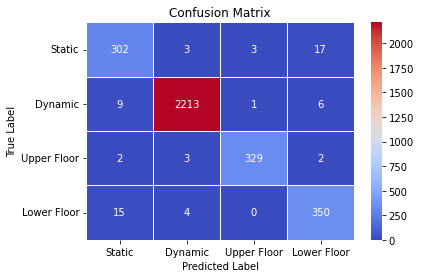

In [27]:

# Print confusion matrix for training data
y_pred_train = trained_AcT_Model.predict(X_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
#print(classification_report(trainy, max_y_pred_train))

# confusion matrix
LABELS = [
    'Static',
    'Dynamic',
    'Upper Floor',
    'Lower Floor'
] 
y_pred_test = trained_AcT_Model.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(Y_test, axis=1)

matrix = metrics.confusion_matrix(max_y_test, max_y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix,
            cmap='coolwarm',
            linecolor='white',
            linewidths=1,
            xticklabels=LABELS,
            yticklabels=LABELS,
            annot=True,
            fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Convert AcT Trained Model to AcT Lite Version

In [28]:
import tensorflow

# Convert the model to a TFLite model
converter = tensorflow.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

## Save Trained AcT Lite Version

In [30]:
# Save the TFLite model to a file
with open(model_Path + 'Bilz_AcT_WAR_TrainedModel_Lite_V4.tflite', 'wb') as f:
    f.write(tflite_model)

try:
    # load the model from a file
    test_load_lite_model = tf.lite.Interpreter(model_Path + 'Bilz_AcT_WAR_TrainedModel_Lite_V4.tflite')
    print("AcT Lite Model saved and loaded successfully !!!")
    
except:
    print("AcT Lite Model is not saved successfully !!!")

AcT Lite Model saved and loaded successfully !!!


## Load Trained AcT Lite Model

In [32]:
import tensorflow as tf

# Load the TensorFlow Lite model.
trained_AcT_Model_Lite_Path = model_Path + 'Bilz_AcT_WAR_TrainedModel_Lite_V4.tflite'
interpreter = tf.lite.Interpreter(model_path=trained_AcT_Model_Lite_Path)
interpreter.allocate_tensors()

# Get input and output details.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print model summary.
print('Input shape:', input_details[0]['shape'])
print('Input type:', input_details[0]['dtype'])
print('Output shape:', output_details[0]['shape'])
print('Output type:', output_details[0]['dtype'])

Input shape: [  1 180   3]
Input type: <class 'numpy.float32'>
Output shape: [1 4]
Output type: <class 'numpy.float32'>


## Evaluation of Trained AcT Lite Model 

Accuracy: 97.61%


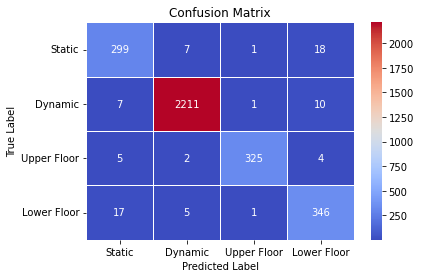

In [33]:
import tensorflow as tf
import numpy as np
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Load the TensorFlow Lite model.
interpreter = tf.lite.Interpreter(trained_AcT_Model_Lite_Path)
interpreter.allocate_tensors()

# Get the input and output details.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load the test data.
X_test = X_test #np.load("X_test.npy")
y_test = Y_test #np.load("y_test.npy")

# Test the model on the test data.
correct = 0
y_pred = []
for i in range(len(X_test)):
    # Preprocess the input data.
    input_data = X_test[i].astype(np.float32)
    input_data = np.expand_dims(input_data, axis=0)

    # Set the input tensor.
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference.
    interpreter.invoke()

    # Get the output tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    prediction = np.argmax(output_data)

    # Check if the prediction is correct.
    if prediction == np.argmax(y_test[i]):
        correct += 1
    y_pred.append(prediction)

accuracy = correct / len(X_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Convert y_test from one-hot encoded array to 1D array of labels.
y_test_labels = np.argmax(y_test, axis=1)

# confusion matrix
LABELS = [
    'Static',
    'Dynamic',
    'Upper Floor',
    'Lower Floor'
] 
matrix = metrics.confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix,
            cmap='coolwarm',
            linecolor='white',
            linewidths=1,
            xticklabels=LABELS,
            yticklabels=LABELS,
            annot=True,
            fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Comparison of Trained AcT and AcT Lite Model

In [34]:
print("Comparison of Trained AcT and AcT Lite Model :")
test_Accuracy_Trained_Model =  (scores[1]*100)
test_Accuracy_Trained_Model_Lite = accuracy * 100
print("Trained AcT Model (Full) - Test Accuracy: %.2f%%" % (test_Accuracy_Trained_Model))
print("Trained AcT Model (Lite) - Test Accuracy: {:.2f}%".format(test_Accuracy_Trained_Model_Lite))


Comparison of Trained AcT and AcT Lite Model :
Trained AcT Model (Full) - Test Accuracy: 98.01%
Trained AcT Model (Lite) - Test Accuracy: 97.61%
